In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm  
from helpers import load_dataset_paths, load_vep_csv, compute_class_average_signal, summarize_results_and_save
import pywt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
import shap
from sklearn.model_selection import LeaveOneOut, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras import Input
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import torch
import torch.nn as nn


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Loading preprocessed files

In [2]:
all_paths = load_dataset_paths()

# Example usage:
prima_files_BC_only = all_paths["PRIMA"]["BC_Only"]
prima_files_RGC_only = all_paths["PRIMA"]["RGC_Only"]
prima_files_BC_and_RGC = all_paths["PRIMA"]["BC_and_RGC"]

# print how many files are in each category
print(f"PRIMA BC_Only files: {len(prima_files_BC_only)}")
print(f"PRIMA RGC_Only files: {len(prima_files_RGC_only)}")
print(f"PRIMA BC_and_RGC files: {len(prima_files_BC_and_RGC)}")


# exclude SNR_summary_BC_and_RGC.csv from the list
prima_files_BC_and_RGC = [f for f in prima_files_BC_and_RGC if not f.endswith("SNR_summary_BC_and_RGC.csv")]
prima_files_RGC_only = [f for f in prima_files_RGC_only if not f.endswith("SNR_summary_RGC_Only.csv")]
prima_files_BC_only = [f for f in prima_files_BC_only if not f.endswith("SNR_summary_BC_Only.csv")]

PRIMA BC_Only files: 146
PRIMA RGC_Only files: 67
PRIMA BC_and_RGC files: 40


Computing class average:   0%|          | 0/145 [00:00<?, ?it/s]

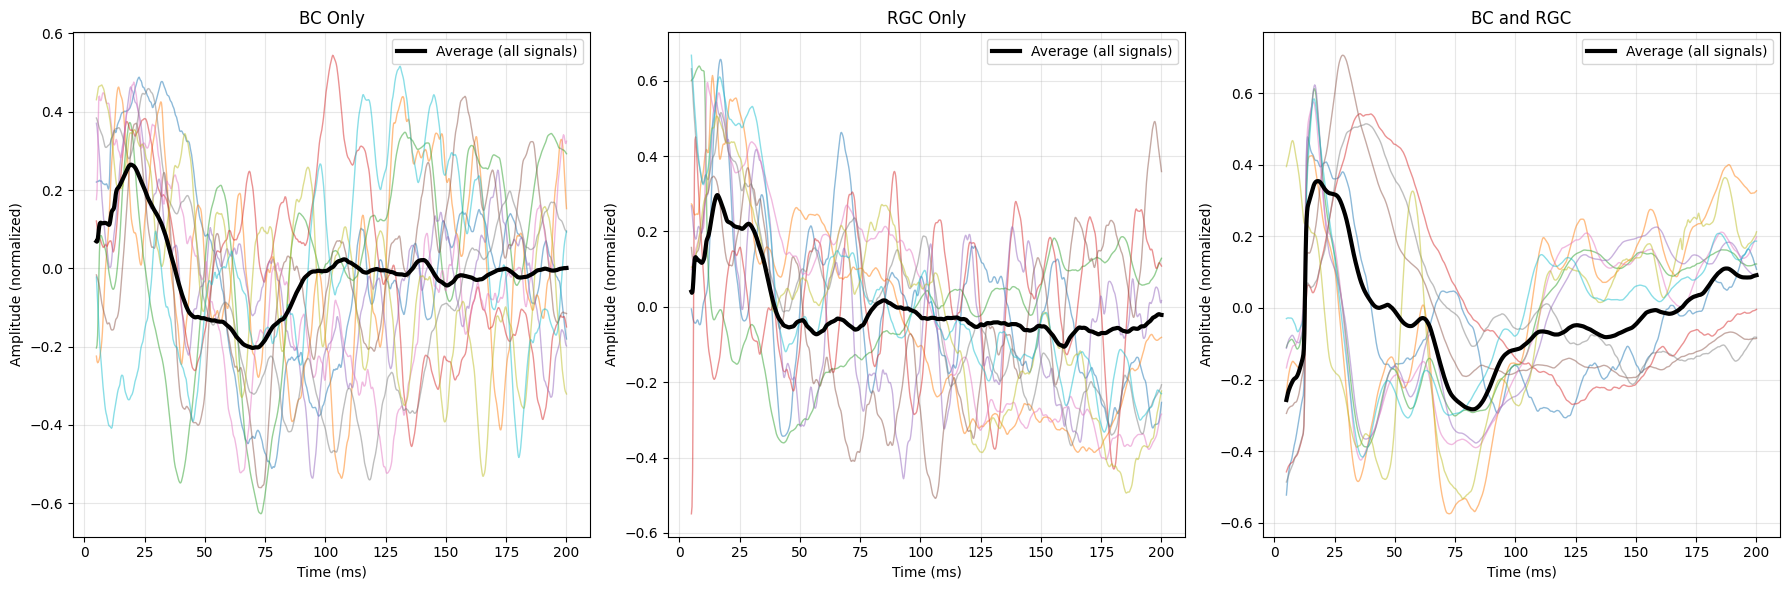

In [3]:
avg_BC_t, avg_BC_sig = compute_class_average_signal(prima_files_BC_only, t_min=5, t_max=200)
avg_RGC_t, avg_RGC_sig = compute_class_average_signal(prima_files_RGC_only, t_min=5, t_max=200)
avg_BC_RGC_t, avg_BC_RGC_sig = compute_class_average_signal(prima_files_BC_and_RGC, t_min=5, t_max=200)


# --- Choose 3 example files per category ---
example_files_BC = prima_files_BC_only[:10]
example_files_RGC = prima_files_RGC_only[:10]
example_files_BC_and_RGC = prima_files_BC_and_RGC[:10]

categories = [
    (example_files_BC, "BC Only", avg_BC_t, avg_BC_sig),
    (example_files_RGC, "RGC Only", avg_RGC_t, avg_RGC_sig),
    (example_files_BC_and_RGC, "BC and RGC", avg_BC_RGC_t, avg_BC_RGC_sig)
]

# --- Plot ---
plt.figure(figsize=(18, 6))

for i, (file_list, title, avg_t, avg_sig) in enumerate(categories, 1):
    plt.subplot(1, 3, i)

    # Plot some example signals
    for file in file_list:
        time, signal = load_vep_csv(file, t_min=5, t_max=200)
        plt.plot(time, signal, alpha=0.5, lw=1)

    # Plot the class-wide average in black
    plt.plot(avg_t, avg_sig, color="k", lw=3, label="Average (all signals)")

    plt.title(title)
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (normalized)")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. DWT 

- cD1: very fast oscillations — like noise or spikes (excluded)
- cD2: slightly slower oscillations (maybe also exclude)
- cD3: still slower
- cD4: near the boundary between “fast” and “slow” activity
- cA4: the “backbone” trend — overall low-frequency envelope

Shape of raw data: (781,)
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]


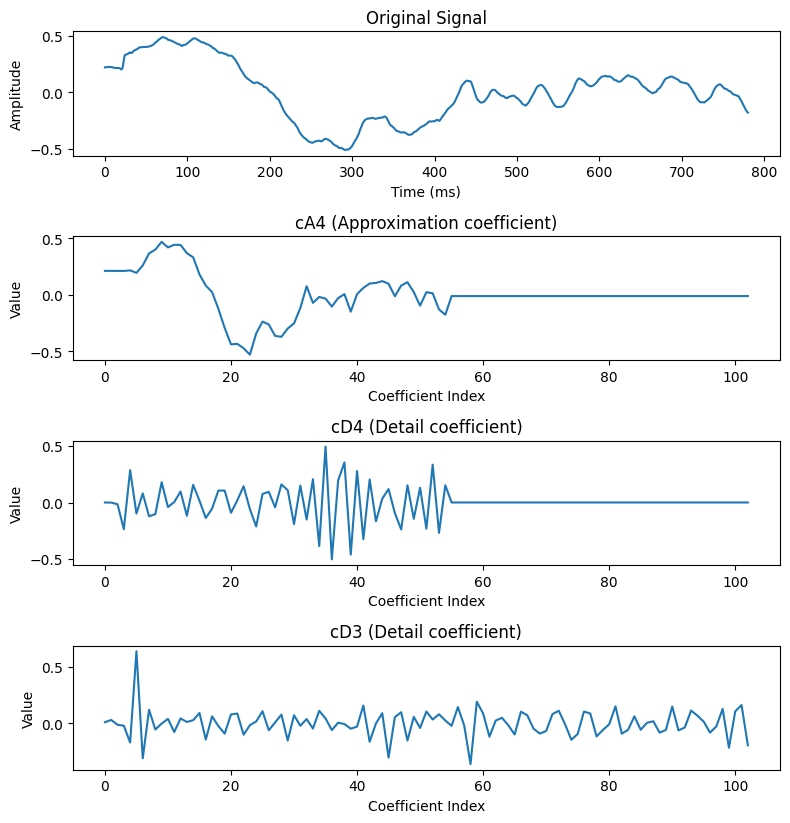

In [ ]:
time, signal = load_vep_csv(prima_files_BC_only[0], t_min=5, t_max=200)
print("Shape of raw data:", signal.shape)


def extract_dwt_features(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    #print("DWT Coefficients lengths before padding:", [len(c) for c in coeffs])
    # drop cD1 (highest-frequency detail) 
    coeffs = coeffs[:-2]  
    max_len = max(len(c) for c in coeffs)
    # Zero-pad each coefficient array to the same length
    padded = [np.pad(c, (0, max_len - len(c))) for c in coeffs]
    #print("DWT Coefficients lengths after padding:", [len(c) for c in padded])
    # scale each coefficient array to have zero mean and unit variance
    padded = [(c - np.mean(c)) / np.std(c) for c in padded]
    # scale to have 1 peak to-peak amplitude
    padded = [c / (np.max(c) - np.min(c)) for c in padded]
    return np.stack(padded, axis=0)

def get_coeff_names(level=4):
    coeff_names = [f"cA{level} (Approximation coefficient)"] + [f"cD{l} (Detail coefficient)" for l in range(level, 0, -1)]
    return coeff_names[:-2]  # drop cD1


dwt_coeffs = extract_dwt_features(signal, wavelet='db4', level=4)
dwt_coeff_names = get_coeff_names(level=4)

# plot the original signal and its DWT coefficients
plt.figure(figsize=(8, 12))
plt.subplot(6, 1, 1)
plt.plot(signal)
plt.title("Original Signal")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
for i, (coeff, name) in enumerate(zip(dwt_coeffs, dwt_coeff_names)):
    plt.subplot(6, 1, i+2)
    plt.plot(coeff)
    #plt.title(f"DWT Coefficient Level {i} {name}")
    plt.title(f"{name}")
    plt.xlabel("Coefficient Index")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()



# 3. Classifier

In [5]:
from tensorflow.keras import backend as K
# ---------------------------------------------------------
#  1D CNN ClassifierMultichannel
# ---------------------------------------------------------

class Multichannel_1DCNN:
    def __init__(self, X, y, n_splits=10, random_state=42):
        self.X = np.array(X)
        self.y = np.array(y)
        self.n_splits = n_splits
        self.random_state = random_state
        self.cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.n_classes = len(np.unique(self.y))
        print("Detected classes:", np.unique(self.y))
        print("Number of classes:", self.n_classes)

    def build_cnn(self, n_points, n_levels):
        model = Sequential([
            Input(shape=(n_points, n_levels)),
            Conv1D(filters=16, kernel_size=5, activation='relu', padding='same'),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(self.n_classes, activation='softmax')
        ])
        model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    # --- Training ---
    def fit(self, epochs=25, batch_size=8):
        y_true, y_pred = [], []
        label_enc = pd.Series(self.y).astype("category")
        label_codes = label_enc.cat.codes
        label_decoder = dict(enumerate(label_enc.cat.categories))

        all_shap_values = []
        for fold, (train_idx, test_idx) in enumerate(self.cv.split(self.X, label_codes), 1):
            print(f"\n--- Fold {fold}/{self.n_splits} ---")
            K.clear_session()
            # Split train/test
            X_train, X_test = self.X[train_idx], self.X[test_idx]
            y_train, y_test = label_codes[train_idx], label_codes[test_idx]
            # One-hot encode labels
            y_train_cat = to_categorical(y_train, num_classes=self.n_classes)
            y_test_cat = to_categorical(y_test, num_classes=self.n_classes)

            # Scaler
            # scaler = StandardScaler()   
            # X_train = scaler.fit_transform(X_train)
            # X_test = scaler.transform(X_test)

            # Early stopping callback
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )

            n_points = X_train.shape[1]
            n_levels = X_train.shape[2]

            model = self.build_cnn(n_points, n_levels)
            history = model.fit(
                X_train, y_train_cat,
                validation_data=(X_test, y_test_cat),
                epochs=epochs,
                batch_size=batch_size,
                verbose=0,
                callbacks=[early_stopping]
            )
            
            # just for debugging
            # print("Model output shape:", model.output_shape)
            # for epoch in range(len(history.history['accuracy'])):
            #     train_acc = history.history['accuracy'][epoch]
            #     val_acc = history.history['val_accuracy'][epoch]
            #     print(f"{epoch+1:5d} | {train_acc:10.4f} | {val_acc:10.4f}")
            best_epoch = np.argmin(history.history['val_loss']) + 1
            best_val_loss = history.history['val_loss'][best_epoch - 1]
            best_val_acc = history.history['val_accuracy'][best_epoch - 1]
            best_train_acc = history.history['accuracy'][best_epoch - 1]
            print(f"[Fold {fold}] Early stopped at epoch {len(history.history['val_loss'])} "
            f"→ best epoch = {best_epoch}, val_loss={best_val_loss:.4f}, val_acc={best_val_acc:.4f}, train_acc={best_train_acc:.4f}")


            preds = model.predict(X_test)
            preds = np.argmax(preds, axis=1) # Convert one-hot to class labels

            y_pred.extend([label_decoder[i] for i in preds])
            y_true.extend([label_decoder[i] for i in y_test])

            # SHAP values
            background = X_train[:min(100, len(X_train))]
            explainer = shap.GradientExplainer(model, background)
            shap_values = explainer.shap_values(X_test) # dimension (number_testsamples_in_fold, n_points, n_levels, n_classes)
            # average over test samples in fold
            shap_values = np.mean(shap_values, axis=0)  # dimension (n_points, n_levels, n_classes)
            all_shap_values.append(shap_values)
        return np.array(y_true), np.array(y_pred), all_shap_values

    def evaluate(self, y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        bal_acc = balanced_accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        cm = confusion_matrix(y_true, y_pred, normalize='true')
        report = classification_report(
            y_true,
            y_pred,
            target_names=np.unique(self.y),
            digits=3,
            output_dict=True 
        )
        print(confusion_matrix(y_true, y_pred, labels=["BC_Only","RGC_Only","BC_and_RGC"]))
        return {
            "accuracy": acc,
            "balanced_accuracy": bal_acc,
            "f1_score": f1,
            "confusion_matrix": cm,
            "report": report,
        }

# 4. Test

--- Experiment 1 ---
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 2/10 ---
[Fold 2] Early stopped at epoch 17 → best epoch = 7, val_loss=0.5830, val_acc=0.5833, train_acc=0.7619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 3/10 ---
[Fold 3] Early stopped at epoch 15 → best epoch = 5, val_loss=0.6574, val_acc=0.3333, train_acc=0.7714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 4/10 ---
[Fold 4] Early stopped at epoch 27 → best epoch = 17, val_loss=0.3770, val_acc=0.9167, train_acc=0.9143
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 5/10 ---
[Fold 5] Early stopped at epoch 22 → best epoch = 12, val_loss=0.6693, val_acc=0.7500, train_acc=0.8762
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 6/10 ---
[Fold 6] Early stopped at epoch 15 → best epoch = 5, val_loss=0.7636, val_acc=0.7500, train_acc=0.7810
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 7/10 ---
[Fold 7] Early stopped at epoch 30 → best epoch = 26, val_loss=0.5717, val_acc=0.7500, train_acc=0.9905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 8/10 ---
[Fold 8] Early stopped at epoch 30 → best epoch = 22, val_loss=0.3897, val_acc=0.7273, train_acc=0.9717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 9/10 ---
[Fold 9] Early stopped at epoch 26 → best epoch = 16, val_loss=0.2987, val_acc=0.9091, train_acc=0.9151
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 10/10 ---
[Fold 10] Early stopped at epoch 28 → best epoch = 18, val_loss=0.4217, val_acc=0.8182, train_acc=0.9717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)


SHAP values shape: [(103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3)]
Averaged SHAP values shape: (103, 3, 3)


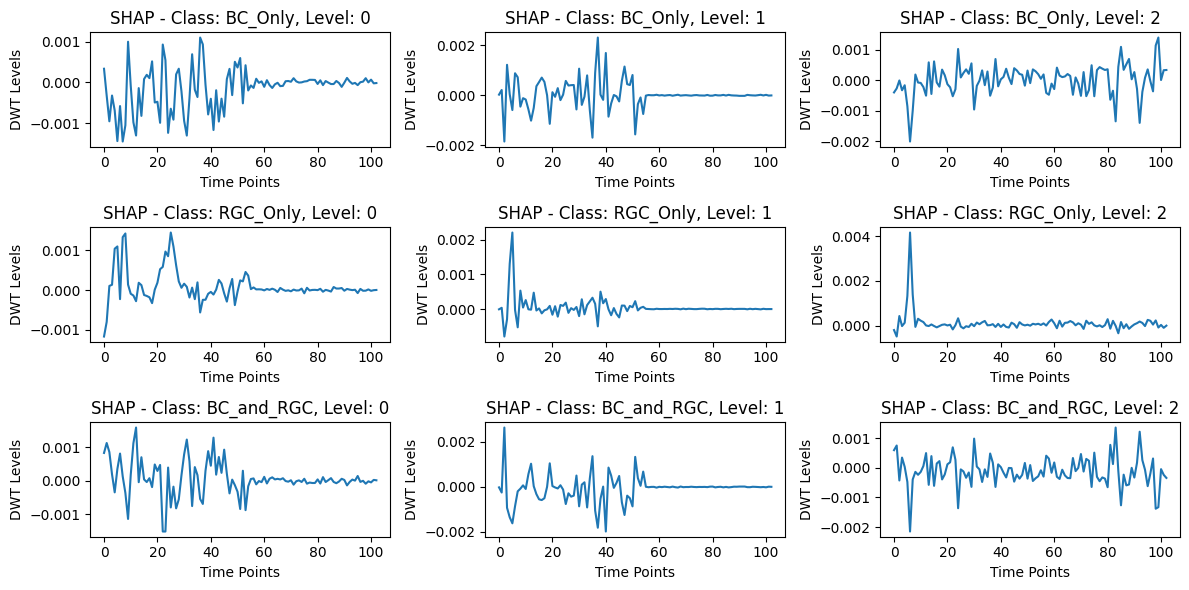

[[26 12  1]
 [15 23  1]
 [ 1  0 38]]
--- Experiment 2 ---
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 2/10 ---
[Fold 2] Early stopped at epoch 19 → best epoch = 9, val_loss=0.5651, val_acc=0.5833, train_acc=0.8286
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 3/10 ---
[Fold 3] Early stopped at epoch 15 → best epoch = 5, val_loss=0.7141, val_acc=0.5000, train_acc=0.7238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 4/10 ---
[Fold 4] Early stopped at epoch 30 → best epoch = 28, val_loss=0.2307, val_acc=1.0000, train_acc=0.9905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 5/10 ---
[Fold 5] Early stopped at epoch 24 → best epoch = 14, val_loss=0.8385, val_acc=0.7500, train_acc=0.8667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 6/10 ---
[Fold 6] Early stopped at epoch 17 → best epoch = 7, val_loss=0.6395, val_acc=0.7500, train_acc=0.7524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 7/10 ---
[Fold 7] Early stopped at epoch 15 → best epoch = 5, val_loss=0.6846, val_acc=0.7500, train_acc=0.7048
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 8/10 ---
[Fold 8] Early stopped at epoch 30 → best epoch = 20, val_loss=0.4599, val_acc=0.7273, train_acc=0.9811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 9/10 ---
[Fold 9] Early stopped at epoch 20 → best epoch = 10, val_loss=0.4958, val_acc=0.7273, train_acc=0.8679
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 10/10 ---
[Fold 10] Early stopped at epoch 30 → best epoch = 29, val_loss=0.4378, val_acc=0.8182, train_acc=0.9906
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)


SHAP values shape: [(103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3)]
Averaged SHAP values shape: (103, 3, 3)


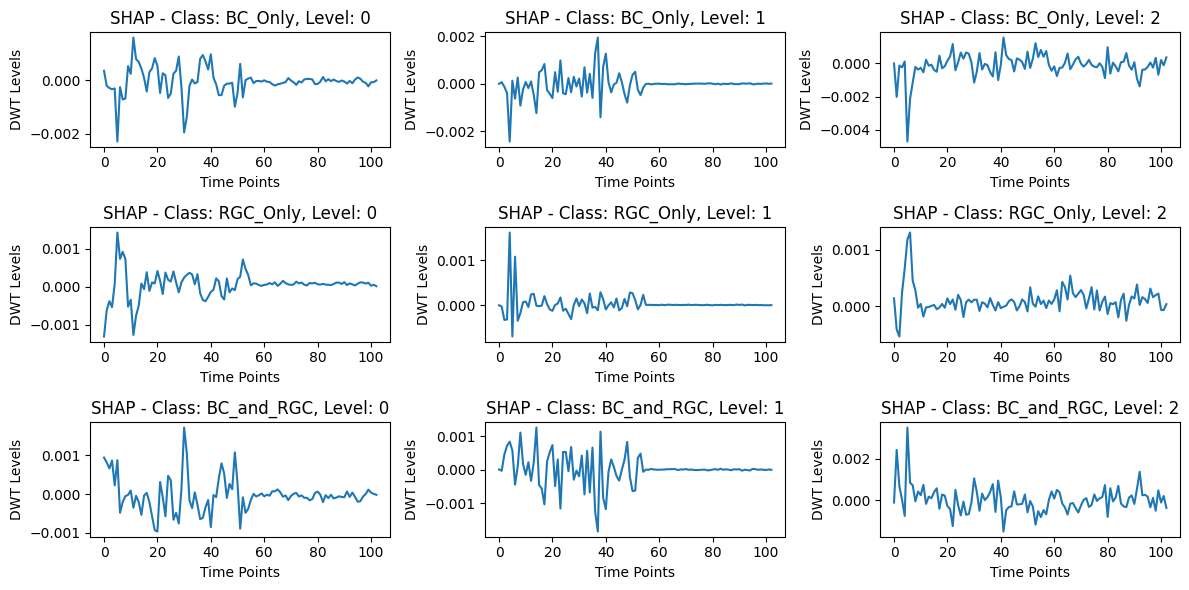

[[26 11  2]
 [12 25  2]
 [ 0  1 38]]
--- Experiment 3 ---
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 2/10 ---
[Fold 2] Early stopped at epoch 21 → best epoch = 11, val_loss=0.6543, val_acc=0.6667, train_acc=0.8667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 3/10 ---
[Fold 3] Early stopped at epoch 16 → best epoch = 6, val_loss=0.6586, val_acc=0.4167, train_acc=0.7333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 4/10 ---
[Fold 4] Early stopped at epoch 30 → best epoch = 30, val_loss=0.3318, val_acc=0.8333, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 5/10 ---
[Fold 5] Early stopped at epoch 30 → best epoch = 27, val_loss=0.6098, val_acc=0.7500, train_acc=0.9905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 6/10 ---
[Fold 6] Early stopped at epoch 17 → best epoch = 7, val_loss=0.8192, val_acc=0.5833, train_acc=0.7333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 7/10 ---
[Fold 7] Early stopped at epoch 30 → best epoch = 27, val_loss=0.3455, val_acc=0.7500, train_acc=0.9905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 8/10 ---
[Fold 8] Early stopped at epoch 30 → best epoch = 27, val_loss=0.3102, val_acc=0.8182, train_acc=0.9906
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 9/10 ---
[Fold 9] Early stopped at epoch 21 → best epoch = 11, val_loss=0.3998, val_acc=0.8182, train_acc=0.8396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 10/10 ---
[Fold 10] Early stopped at epoch 30 → best epoch = 28, val_loss=0.3804, val_acc=0.8182, train_acc=0.9717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)


SHAP values shape: [(103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3)]
Averaged SHAP values shape: (103, 3, 3)


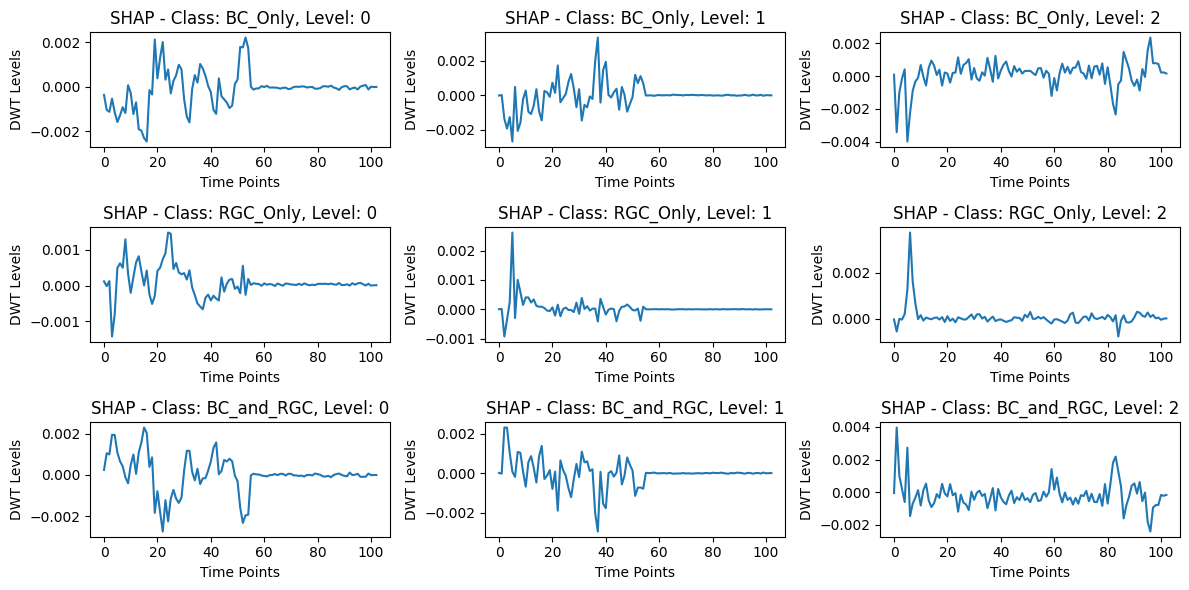

[[27 11  1]
 [15 23  1]
 [ 2  1 36]]
--- Experiment 4 ---
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 2/10 ---
[Fold 2] Early stopped at epoch 23 → best epoch = 13, val_loss=0.5629, val_acc=0.6667, train_acc=0.8952
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 3/10 ---
[Fold 3] Early stopped at epoch 16 → best epoch = 6, val_loss=0.7390, val_acc=0.5000, train_acc=0.8000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 4/10 ---
[Fold 4] Early stopped at epoch 30 → best epoch = 29, val_loss=0.2826, val_acc=0.9167, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 5/10 ---
[Fold 5] Early stopped at epoch 22 → best epoch = 12, val_loss=0.7311, val_acc=0.6667, train_acc=0.8952
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 6/10 ---
[Fold 6] Early stopped at epoch 18 → best epoch = 8, val_loss=0.7559, val_acc=0.5833, train_acc=0.7905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 7/10 ---
[Fold 7] Early stopped at epoch 30 → best epoch = 28, val_loss=0.4623, val_acc=0.7500, train_acc=0.9810
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 8/10 ---
[Fold 8] Early stopped at epoch 30 → best epoch = 30, val_loss=0.3866, val_acc=0.8182, train_acc=0.9811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 9/10 ---
[Fold 9] Early stopped at epoch 20 → best epoch = 10, val_loss=0.4290, val_acc=0.8182, train_acc=0.8302
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 10/10 ---
[Fold 10] Early stopped at epoch 20 → best epoch = 10, val_loss=0.5247, val_acc=0.8182, train_acc=0.8585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)


SHAP values shape: [(103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3)]
Averaged SHAP values shape: (103, 3, 3)


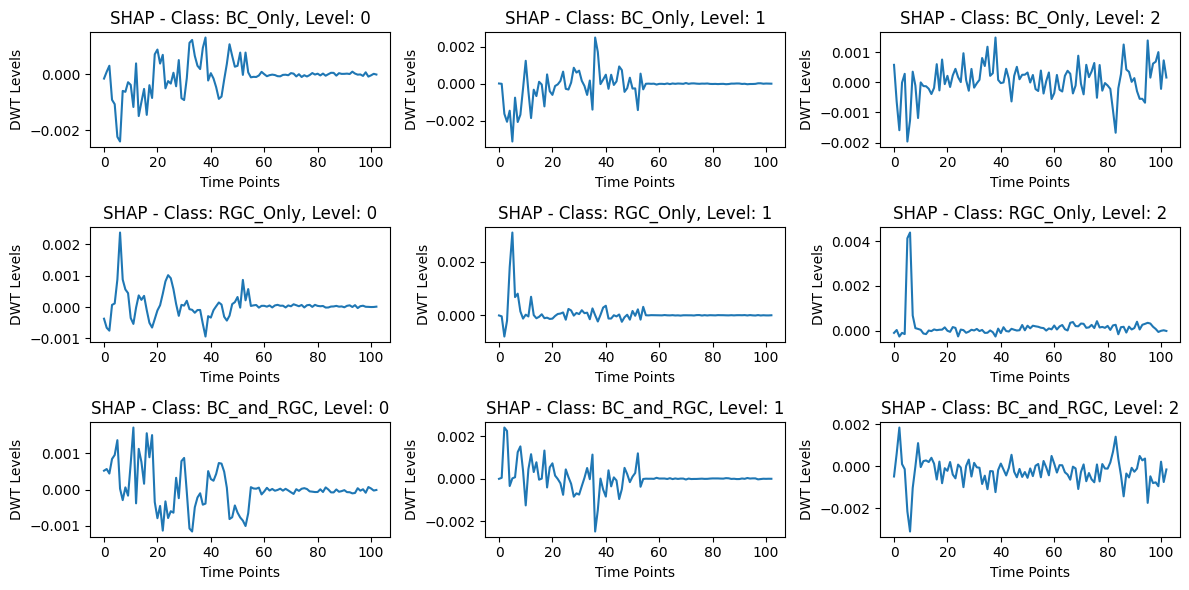

[[26 11  2]
 [14 23  2]
 [ 1  0 38]]
--- Experiment 5 ---
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before padding: [55, 55, 103, 200, 394]
DWT Coefficients lengths before 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 2/10 ---
[Fold 2] Early stopped at epoch 27 → best epoch = 17, val_loss=0.5185, val_acc=0.6667, train_acc=0.9619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 3/10 ---
[Fold 3] Early stopped at epoch 18 → best epoch = 8, val_loss=0.6615, val_acc=0.5000, train_acc=0.7524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 4/10 ---
[Fold 4] Early stopped at epoch 25 → best epoch = 15, val_loss=0.3961, val_acc=0.8333, train_acc=0.9429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 5/10 ---
[Fold 5] Early stopped at epoch 30 → best epoch = 23, val_loss=0.6172, val_acc=0.6667, train_acc=0.9905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 6/10 ---
[Fold 6] Early stopped at epoch 14 → best epoch = 4, val_loss=0.8394, val_acc=0.6667, train_acc=0.7429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 7/10 ---
[Fold 7] Early stopped at epoch 29 → best epoch = 19, val_loss=0.4886, val_acc=0.8333, train_acc=0.9143
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 8/10 ---
[Fold 8] Early stopped at epoch 30 → best epoch = 28, val_loss=0.1929, val_acc=1.0000, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 9/10 ---
[Fold 9] Early stopped at epoch 24 → best epoch = 14, val_loss=0.4455, val_acc=0.6364, train_acc=0.9151
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)



--- Fold 10/10 ---
[Fold 10] Early stopped at epoch 29 → best epoch = 19, val_loss=0.4931, val_acc=0.8182, train_acc=0.9340
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 103, 3))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 103, 3))']
  warnings.warn(msg)


SHAP values shape: [(103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3), (103, 3, 3)]
Averaged SHAP values shape: (103, 3, 3)


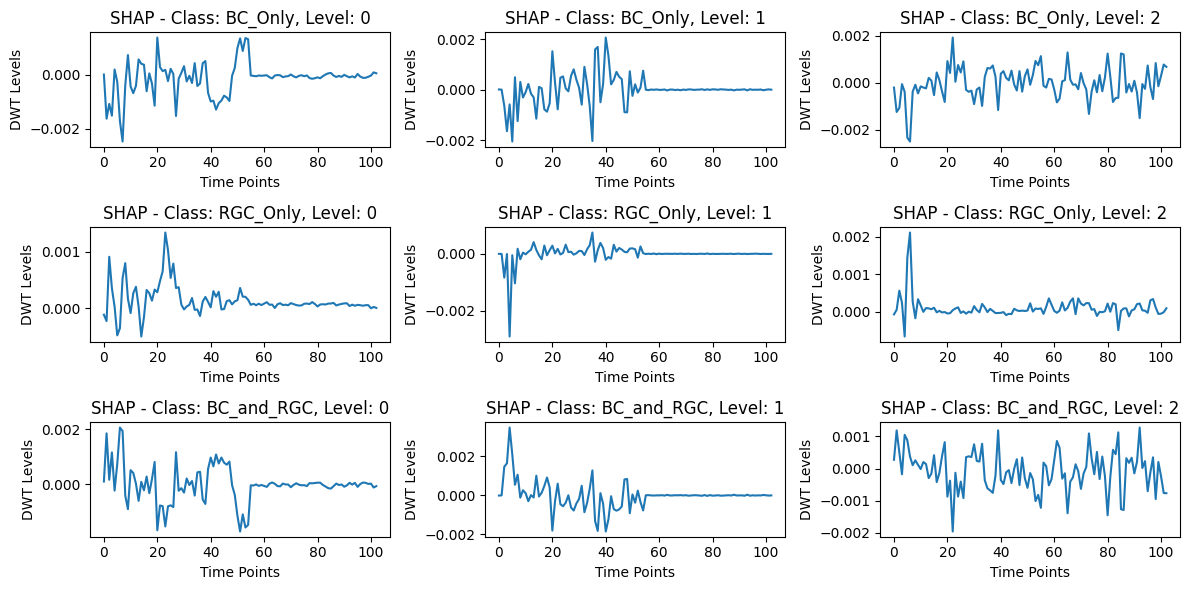

[[27 10  2]
 [15 23  1]
 [ 0  1 38]]


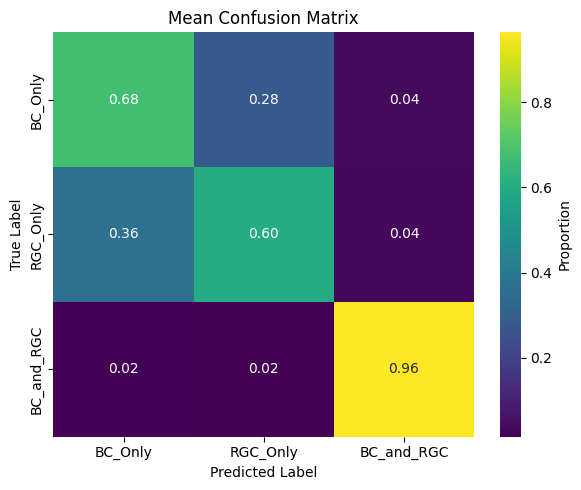

In [6]:
average_results = {}
results = []
mean_shap_values = []
all_conf_matrices = []
for experiments in range(5):
    print(f"--- Experiment {experiments + 1} ---")
    np.random.seed(42)
    no_files = min(len(prima_files_BC_only), len(prima_files_RGC_only), len(prima_files_BC_and_RGC))
    sampled_BC = np.random.choice(prima_files_BC_only, no_files, replace=False)
    sampled_RGC = np.random.choice(prima_files_RGC_only, no_files, replace=False)
    sampled_BC_and_RGC = np.random.choice(prima_files_BC_and_RGC, no_files, replace=False)

    X, labels = [], []
    for file in sampled_BC:
        _, signal = load_vep_csv(file, t_min=5, t_max=200)
        X.append(extract_dwt_features(signal, wavelet='db4', level=4))
        labels.append("BC_Only")

    for file in sampled_RGC:
        _, signal = load_vep_csv(file, t_min=5, t_max=200)
        X.append(extract_dwt_features(signal, wavelet='db4', level=4))
        labels.append("RGC_Only")

    for file in sampled_BC_and_RGC:
        _, signal = load_vep_csv(file, t_min=5, t_max=200)
        X.append(extract_dwt_features(signal, wavelet='db4', level=4))
        labels.append("BC_and_RGC")
    X = np.stack(X, axis=0)                     # (n_samples, n_levels, n_points)
    X = np.transpose(X, (0, 2, 1)).astype('float32')  # (n_samples, n_points, n_levels)


    n_train = len(X)
    batch_size = max(4, min(32, n_train // 12))
    if n_train < 100:
        epochs = 50
    else:
        epochs = 30
    print(f"Training samples: {n_train}, batch size: {batch_size}, epochs: {epochs}")

    clf = Multichannel_1DCNN(X, labels, n_splits=10, random_state=42)
    y_true, y_pred, shap_values = clf.fit(epochs=epochs, batch_size=batch_size)
    print("SHAP values shape:", [sv.shape for sv in shap_values])
    # average over folds
    shap_values = np.mean(shap_values, axis=0) # dimension (200, 4, 3) = (n_points, n_levels, n_classes)
    print("Averaged SHAP values shape:", shap_values.shape) 
    mean_shap_values.append(shap_values)

    plt.figure(figsize=(12, 6))
    class_names = ["BC_Only", "RGC_Only", "BC_and_RGC"]
    for i, class_name in enumerate(class_names):
        for j in range(shap_values.shape[1]):
            plt.subplot(len(class_names), shap_values.shape[1], i * shap_values.shape[1] + j + 1)
            plt.title(f"SHAP - Class: {class_name}, Level: {j}")
            plt.plot(shap_values[:, :, i][:, j])
            plt.xlabel("Time Points")
            plt.ylabel("DWT Levels")
    plt.tight_layout()
    plt.show()

    unique_labels = np.unique(labels)
    metrics = clf.evaluate(y_true, y_pred)

    results.append({
            "Accuracy": metrics["accuracy"],
            "BalancedAcc": metrics["balanced_accuracy"],
            "F1": metrics["f1_score"],
            "Acc BC_Only": metrics["report"]["BC_Only"]["recall"],
            "Acc RGC_and_BC": metrics["report"]["BC_and_RGC"]["recall"],
            "Acc RGC_Only": metrics["report"]["RGC_Only"]["recall"],
        })
    all_conf_matrices.append(
        confusion_matrix(
            y_true, y_pred, labels=["BC_Only", "RGC_Only", "BC_and_RGC"]
        )
    )

accs = [r["Accuracy"] for r in results]
balanced_accs = [r["BalancedAcc"] for r in results]
f1s = [r["F1"] for r in results]
bc_accs = [float(r["Acc BC_Only"]) for r in results]
rgc_accs = [float(r["Acc RGC_Only"]) for r in results]
bc_rgc_accs = [float(r["Acc RGC_and_BC"]) for r in results]

average_results = {
    "Accuracy_mean": np.mean(accs),
    "Accuracy_std": np.std(accs),
    "BalancedAcc_mean": np.mean(balanced_accs),
    "BalancedAcc_std": np.std(balanced_accs),
    "F1_mean": np.mean(f1s),
    "F1_std": np.std(f1s),

    # per-class accuracies (recall)
    "Acc_BC_Only_mean": np.mean(bc_accs),
    "Acc_BC_Only_std": np.std(bc_accs),
    "Acc_RGC_Only_mean": np.mean(rgc_accs),
    "Acc_RGC_Only_std": np.std(rgc_accs),
    "Acc_BC_and_RGC_mean": np.mean(bc_rgc_accs),
    "Acc_BC_and_RGC_std": np.std(bc_rgc_accs),
}
mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
mean_conf_matrix = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True)

labels = ["BC_Only", "RGC_Only", "BC_and_RGC"] 
plt.figure(figsize=(6,5)) 
sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="viridis", xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Proportion'}) 
plt.title(f"Mean Confusion Matrix") 
plt.xlabel("Predicted Label") 
plt.ylabel("True Label") 
plt.tight_layout()
plt.show()

In [11]:
# compute and print average results
print("Average Results over 5 experiments:")
for k, v in average_results.items():
    print(f"{k}: {v:.4f}")

Average Results over 5 experiments:
Accuracy_mean: 0.7470
Accuracy_std: 0.0087
BalancedAcc_mean: 0.7470
BalancedAcc_std: 0.0087
F1_mean: 0.7446
F1_std: 0.0076
Acc_BC_Only_mean: 0.6769
Acc_BC_Only_std: 0.0126
Acc_RGC_Only_mean: 0.6000
Acc_RGC_Only_std: 0.0205
Acc_BC_and_RGC_mean: 0.9641
Acc_BC_and_RGC_std: 0.0205


# 5.Explain

In [8]:
## TODO: 
# 1. Collect average SHAP values across all experiments 
# 2. Plot the 95 percentile of SHAP values not per level but across all levels per class!

In [9]:
# Collect average SHAP values across all experiments 
mean_shap_values_global = np.mean(np.stack(mean_shap_values, axis=0), axis=0) # shape (n_points, n_levels, n_classes) 
print("Global mean SHAP shape:", mean_shap_values_global.shape) 

mean_signals = {} 
mean_signals["BC_Only"] = avg_BC_sig 
mean_signals["RGC_Only"] = avg_RGC_sig 
mean_signals["BC_and_RGC"] = avg_BC_RGC_sig 
mean_dwt_features = {} 
mean_dwt_features["BC_Only"] = extract_dwt_features(avg_BC_sig, wavelet='db4', level=4) 
mean_dwt_features["RGC_Only"] = extract_dwt_features(avg_RGC_sig, wavelet='db4', level=4) 
mean_dwt_features["BC_and_RGC"] = extract_dwt_features(avg_BC_RGC_sig, wavelet='db4', level=4) 

Global mean SHAP shape: (103, 3, 3)
DWT Coefficients lengths before padding: [69, 69, 131, 255, 503]
DWT Coefficients lengths before padding: [69, 69, 131, 255, 503]
DWT Coefficients lengths before padding: [69, 69, 131, 255, 503]


Global mean SHAP shape: (103, 3, 3)
SHAP thresholds per class at 98 percentile: [0.00151302 0.00088125 0.00119402]
DWT Coefficients lengths before padding: [69, 69, 131, 255, 503]
DWT Coefficients lengths before padding: [69, 69, 131, 255, 503]
DWT Coefficients lengths before padding: [69, 69, 131, 255, 503]


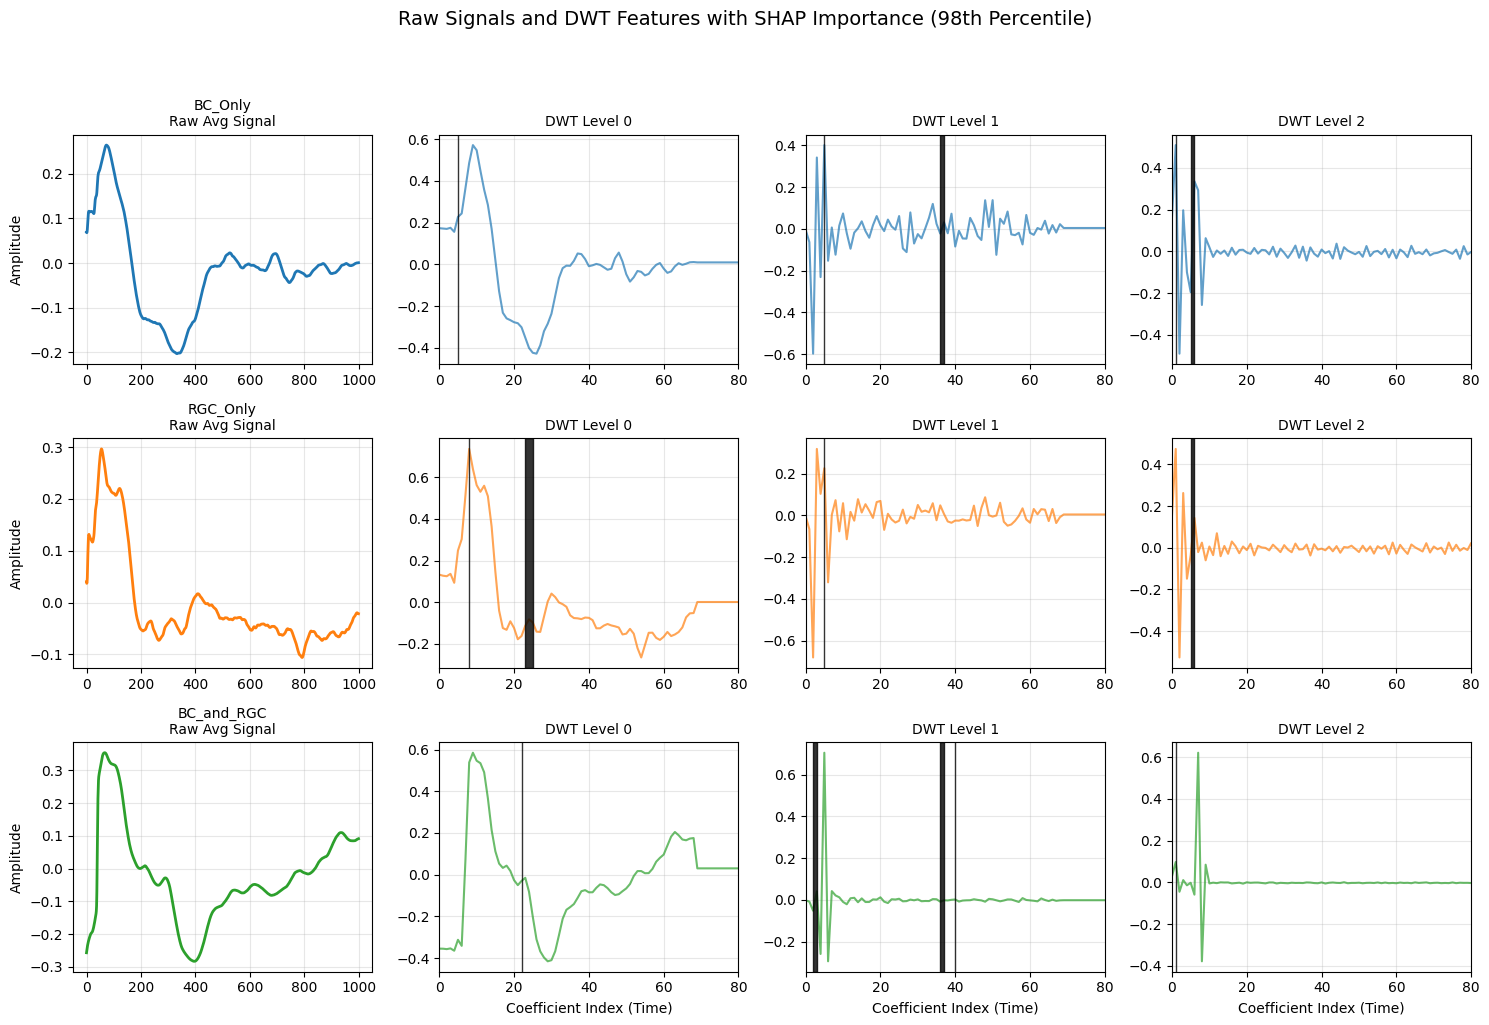

In [18]:
N_LEVELS = 3
ABS_SHAP_THRESHOLD_PERCENTILE = 98
# Average SHAP values across all experiments 
mean_shap_values_global = np.mean(np.stack(mean_shap_values, axis=0), axis=0) # shape (n_points, n_levels, n_classes) 
print("Global mean SHAP shape:", mean_shap_values_global.shape) 
# find 98th percentile threshold for each class
shap_thresholds = np.percentile(np.abs(mean_shap_values_global), ABS_SHAP_THRESHOLD_PERCENTILE, axis=(0, 1))
print("SHAP thresholds per class at", ABS_SHAP_THRESHOLD_PERCENTILE, "percentile:", shap_thresholds)

mean_signals = {} 
mean_signals["BC_Only"] = avg_BC_sig 
mean_signals["RGC_Only"] = avg_RGC_sig 
mean_signals["BC_and_RGC"] = avg_BC_RGC_sig 
mean_dwt_features = {} 
mean_dwt_features["BC_Only"] = extract_dwt_features(avg_BC_sig, wavelet='db4', level=4) 
mean_dwt_features["RGC_Only"] = extract_dwt_features(avg_RGC_sig, wavelet='db4', level=4) 
mean_dwt_features["BC_and_RGC"] = extract_dwt_features(avg_BC_RGC_sig, wavelet='db4', level=4) 

label_colors = {
    "BC_Only": 'C0',  # Blue
    "RGC_Only": 'C1', # Orange
    "BC_and_RGC": 'C2' # Green
}
unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]
signal_type = "DWT" # Used in plot title

plt.figure(figsize=(15, 10))

for c_idx, class_label in enumerate(unique_labels):
    # Get class-specific data
    avg_sig = mean_signals[class_label] # Shape: (N_points,)
    avg_dwt = mean_dwt_features[class_label] # Shape: (N_levels, N_points)
    mean_shap_c = mean_shap_values_global[:, :, c_idx] # Shape: (N_points, N_levels)
    color = label_colors[class_label]
    
    
    # 1. Plot: Raw Average Signal (First column)
    ax_raw = plt.subplot(len(unique_labels), N_LEVELS + 1, c_idx * (N_LEVELS + 1) + 1)
    ax_raw.plot(avg_sig, color=color, lw=2)
    ax_raw.set_title(f"{class_label}\nRaw Avg Signal", fontsize=10)
    ax_raw.set_ylabel("Amplitude")
    ax_raw.grid(True, alpha=0.3)
    
    # 2. Plot: DWT Levels (Next 4 columns)
    for l_idx in range(N_LEVELS): # l_idx = 0 to 3
        ax_dwt = plt.subplot(len(unique_labels), N_LEVELS + 1, c_idx * (N_LEVELS + 1) + 2 + l_idx)
        ax_dwt.set_xlim(0, 80)
        
        dwt_level_sig = avg_dwt[l_idx, :] # Shape: (N_points,)
        shap_level_vals = mean_shap_c[:, l_idx] # Shape: (N_points,)
        # --- Plot DWT Signal ---
        ax_dwt.plot(dwt_level_sig, color=color, alpha=0.7)
        ax_dwt.set_title(f"DWT Level {l_idx}", fontsize=10)
        ax_dwt.grid(True, alpha=0.3)
        
        # --- Highlight SHAP Importance ---
        abs_shap = np.abs(shap_level_vals)
        important_indices = np.where(abs_shap >= shap_thresholds[c_idx])[0]
        #threshold = np.percentile(abs_shap, ABS_SHAP_THRESHOLD_PERCENTILE) 
        #important_indices = np.where(abs_shap >= threshold)[0]
        
        # Simple highlighting for the DWT feature plot
        if important_indices.size > 0:
            # Group continuous indices to create segments
            segments = []
            if important_indices.size > 0:
                start = important_indices[0]
                end = important_indices[0]
                for i in range(1, len(important_indices)):
                    if important_indices[i] == important_indices[i-1] + 1:
                        end = important_indices[i]
                    else:
                        segments.append((start, end))
                        start = important_indices[i]
                        end = important_indices[i]
                segments.append((start, end))
            
            # Use SHAP value magnitude for y-axis placement of the highlight
            y_min, y_max = ax_dwt.get_ylim()

            for start, end in segments:
                # Highlight the segment with a vertical span
                ax_dwt.axvspan(start, end, 
                               alpha=0.8, 
                               color='k', 
                               zorder=10)
        
        # Set shared labels for the bottom row
        if c_idx == len(unique_labels) - 1:
            ax_dwt.set_xlabel("Coefficient Index (Time)")
            
# Add a global title for context
plt.suptitle(f"Raw Signals and DWT Features with SHAP Importance ({ABS_SHAP_THRESHOLD_PERCENTILE}th Percentile)", 
             fontsize=14, 
             y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to fit suptitle
plt.show()



In [ ]:
# N_LEVELS = 4 
# # Average SHAP values across all experiments 
# mean_shap_values_global = np.mean(np.stack(mean_shap_values, axis=0), axis=0) # shape (n_points, n_levels, n_classes) 
# print("Global mean SHAP shape:", mean_shap_values_global.shape) 


# mean_signals = {} 
# mean_signals["BC_Only"] = avg_BC_sig 
# mean_signals["RGC_Only"] = avg_RGC_sig 
# mean_signals["BC_and_RGC"] = avg_BC_RGC_sig 
# mean_dwt_features = {} 
# mean_dwt_features["BC_Only"] = extract_dwt_features(avg_BC_sig, wavelet='db4', level=4) 
# mean_dwt_features["RGC_Only"] = extract_dwt_features(avg_RGC_sig, wavelet='db4', level=4) 
# mean_dwt_features["BC_and_RGC"] = extract_dwt_features(avg_BC_RGC_sig, wavelet='db4', level=4) 

# label_colors = {
#     "BC_Only": 'C0',  # Blue
#     "RGC_Only": 'C1', # Orange
#     "BC_and_RGC": 'C2' # Green
# }
# unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]
# ABS_SHAP_THRESHOLD_PERCENTILE = 98
# signal_type = "DWT" # Used in plot title

# plt.figure(figsize=(15, 10))

# for c_idx, class_label in enumerate(unique_labels):
#     # Get class-specific data
#     avg_sig = mean_signals[class_label] # Shape: (N_points,)
#     avg_dwt = mean_dwt_features[class_label] # Shape: (N_levels, N_points)
#     mean_shap_c = mean_shap_values_global[:, :, c_idx] # Shape: (N_points, N_levels)
#     color = label_colors[class_label]
    
    
#     # 1. Plot: Raw Average Signal (First column)
#     ax_raw = plt.subplot(len(unique_labels), N_LEVELS + 1, c_idx * (N_LEVELS + 1) + 1)
#     ax_raw.plot(avg_sig, color=color, lw=2)
#     ax_raw.set_title(f"{class_label}\nRaw Avg Signal", fontsize=10)
#     ax_raw.set_ylabel("Amplitude")
#     ax_raw.grid(True, alpha=0.3)
    
#     # 2. Plot: DWT Levels (Next 4 columns)
#     for l_idx in range(N_LEVELS): # l_idx = 0 to 3
#         ax_dwt = plt.subplot(len(unique_labels), N_LEVELS + 1, c_idx * (N_LEVELS + 1) + 2 + l_idx)
#         ax_dwt.set_xlim(0, 20)
        
#         dwt_level_sig = avg_dwt[l_idx, :] # Shape: (N_points,)
#         shap_level_vals = mean_shap_c[:, l_idx] # Shape: (N_points,)
#         # --- Plot DWT Signal ---
#         ax_dwt.plot(dwt_level_sig, color=color, alpha=0.7)
#         ax_dwt.set_title(f"DWT Level {l_idx+1}", fontsize=10)
#         ax_dwt.grid(True, alpha=0.3)
        
#         # --- Highlight SHAP Importance ---
#         abs_shap = np.abs(shap_level_vals)
#         threshold = np.percentile(abs_shap, ABS_SHAP_THRESHOLD_PERCENTILE) 
#         important_indices = np.where(abs_shap >= threshold)[0]
        
#         # Simple highlighting for the DWT feature plot
#         if important_indices.size > 0:
#             # Group continuous indices to create segments
#             segments = []
#             if important_indices.size > 0:
#                 start = important_indices[0]
#                 end = important_indices[0]
#                 for i in range(1, len(important_indices)):
#                     if important_indices[i] == important_indices[i-1] + 1:
#                         end = important_indices[i]
#                     else:
#                         segments.append((start, end))
#                         start = important_indices[i]
#                         end = important_indices[i]
#                 segments.append((start, end))
            
#             # Use SHAP value magnitude for y-axis placement of the highlight
#             y_min, y_max = ax_dwt.get_ylim()

#             for start, end in segments:
#                 # Highlight the segment with a vertical span
#                 ax_dwt.axvspan(start, end, 
#                                alpha=0.8, 
#                                color='k', 
#                                zorder=10)
        
#         # Set shared labels for the bottom row
#         if c_idx == len(unique_labels) - 1:
#             ax_dwt.set_xlabel("Coefficient Index (Time)")
            
# # Add a global title for context
# plt.suptitle(f"Raw Signals and DWT Features with SHAP Importance ({ABS_SHAP_THRESHOLD_PERCENTILE}th Percentile)", 
#              fontsize=14, 
#              y=1.02)
# plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to fit suptitle
# plt.show()

